In [3]:
import numpy as np
import matplotlib.pyplot as plt
def create_spiral_data(samples, classes):
    X = np.zeros((samples*classes, 2))
    y = np.zeros(samples*classes, dtype='uint8')
    for class_number in range(classes):
        ix = range(samples*class_number, samples*(class_number+1))
        r = np.linspace(0.0, 1, samples)
        t = np.linspace(class_number*4, (class_number+1)*4, samples) + np.random.randn(samples)*0.2
        X[ix] = np.c_[r*np.sin(t*2.5), r*np.cos(t*2.5)]
        y[ix] = class_number
    return X, y

In [23]:
sample_size=300
classes=3
X,y=create_spiral_data(sample_size,classes)
X.shape,y.shape

((900, 2), (900,))

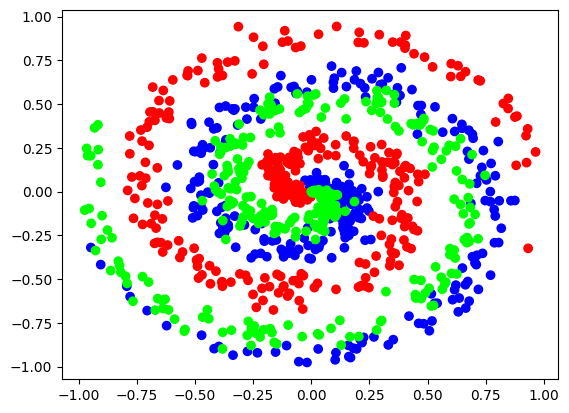

In [24]:
plt.scatter(X[:,0],X[:,1],c=y,cmap='brg')
plt.show()

In [35]:
y_one_hot_encoded=np.eye(classes)[y]
y_one_hot_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [211]:
from numpy.typing import NDArray

class DenseLayer:
    def __init__(self,neurons:int,inputs:int):
        # self.weights=np.random.normal(size=neurons*inputs,loc=5,scale=2).reshape(neurons,inputs)
        self.weights=np.random.randn(neurons,inputs)
        self.biases=np.random.randn(1,neurons)
        
    def forward(self,inputs:NDArray):
        self.inputs=inputs
        self.output=np.dot(self.inputs,self.weights.T)+self.biases
        return self.output
        
    def backward(self,d_outputs:NDArray):
        self.d_weights=np.dot(self.inputs.T,d_outputs).T
        self.d_biases=np.sum(d_outputs,axis=0,keepdims=True)
        self.d_inputs=np.dot(d_outputs,self.weights)
        return self.d_inputs

In [217]:
class ReluActivation:
    def forward(self,inputs:NDArray):
        self.inputs=inputs
        self.output=np.where(self.inputs<=0,0.1*self.inputs,self.inputs)
        return self.output
    
    def backward(self,d_outputs:NDArray):
        self.d_inputs=np.where(self.inputs<=0,0.1,1)*d_outputs
        return self.d_inputs

class SoftmaxActivation:
    def forward(self,inputs:NDArray):
        normalized_inputs=inputs-np.max(inputs,axis=1,keepdims=True)
        exp_inputs=np.exp(normalized_inputs)
        return exp_inputs/np.sum(exp_inputs,axis=1,keepdims=True)
    def backward(self,d_outputs:NDArray):
        pass

class CrossEntrophyLoss:
    def forward(self,y_pred:NDArray,y_true:NDArray):
        epsilon = 1e-7
        output=-np.sum(np.log(np.clip(y_pred,epsilon,1-epsilon))*y_true,axis=1,keepdims=True)
        return output
    
    def backward(self,d_outputs:NDArray):
        # not required for now
        pass

class SoftMaxActivationWithCrossEnrophyLoss:
    def __init__(self):
        self.activation=SoftmaxActivation()
        self.loss_function=CrossEntrophyLoss()
    
    def forward(self,inputs:NDArray,y_true:NDArray):
        self.inputs=inputs
        self.output=self.activation.forward(inputs)
        return self.loss_function.forward(self.output,y_true)


    def backward(self,y_true:NDArray):
        self.d_inputs=self.inputs-y_true
        self.d_inputs/=self.d_inputs.shape[0]

class GradientDescentOptimizer:
    def __init__(self,learning_rate):
        self.learning_rate=learning_rate
        
    def update_params(self,layer:DenseLayer):
        # print(f'layer weights: {layer.weights.shape}\n layer d_weights : {layer.d_weights.shape}')
        layer.weights-=self.learning_rate*layer.d_weights
        layer.biases-=self.learning_rate*layer.d_biases

In [267]:
layer1=DenseLayer(128,2)
activation1=ReluActivation()
layer2=DenseLayer(3,128)
activation2=SoftMaxActivationWithCrossEnrophyLoss()
epochs=100000
loss_values=[]
optimizer=GradientDescentOptimizer(learning_rate=0.001)
for i in range(epochs):
    layer1.forward(X)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    losses=activation2.forward(layer2.output,np.eye(classes)[y])
    if i%1000==0:
        print(f'Loss: {np.mean(losses)}\tAccuracy:{np.mean(y==np.argmax(activation2.output,axis=1))}')
        loss_values.append([i,np.mean(losses),np.mean(y==np.argmax(activation2.output,axis=1))])
    activation2.backward(np.eye(classes)[y])
    layer2.backward(activation2.d_inputs)
    activation1.backward(layer2.d_inputs)
    layer1.backward(activation1.d_inputs)
    optimizer.update_params(layer=layer1)
    optimizer.update_params(layer=layer2)

Loss: 0.8963628818840679	Accuracy:0.7733333333333333
Loss: 0.8959627580052633	Accuracy:0.7744444444444445
Loss: 0.8955752102382034	Accuracy:0.7755555555555556
Loss: 0.895213042560423	Accuracy:0.7755555555555556
Loss: 0.8948499627513561	Accuracy:0.7777777777777778
Loss: 0.8944896273279019	Accuracy:0.7766666666666666
Loss: 0.8941293400949202	Accuracy:0.7777777777777778
Loss: 0.893758964840959	Accuracy:0.7788888888888889
Loss: 0.8934002119412892	Accuracy:0.7788888888888889
Loss: 0.8930495101807657	Accuracy:0.78
Loss: 0.8926706251834489	Accuracy:0.7811111111111111
Loss: 0.8923000446193065	Accuracy:0.7811111111111111
Loss: 0.8919629166229287	Accuracy:0.7822222222222223
Loss: 0.8916437226164272	Accuracy:0.7822222222222223
Loss: 0.8913239649176623	Accuracy:0.7822222222222223
Loss: 0.8910005183237582	Accuracy:0.7822222222222223
Loss: 0.8906648283564853	Accuracy:0.7844444444444445
Loss: 0.8903307499495242	Accuracy:0.7844444444444445
Loss: 0.8900143040099258	Accuracy:0.7855555555555556
Loss: 0.8

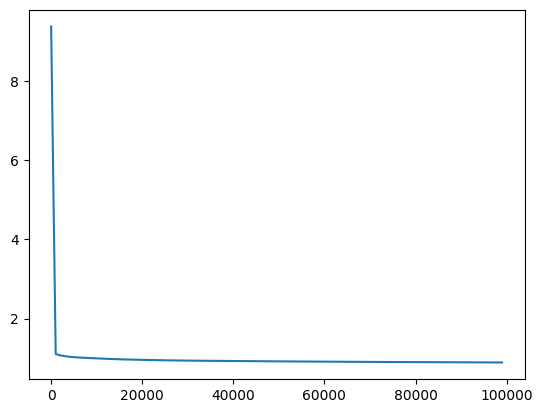

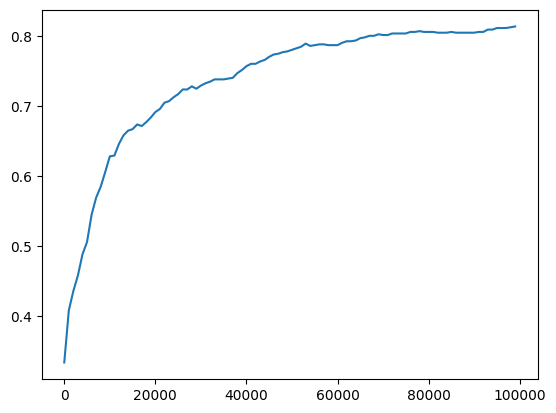

In [221]:
loss_points=np.array(loss_values)
plt.plot(loss_points[:,0],loss_points[:,1])
plt.show()
plt.plot(loss_points[:,0],loss_points[:,2])
plt.show()

In [252]:
class SGDOptimizerWithMomentum:
    def __init__(self,alpha=1,decay=0,momentum=0):
        self.alpha=alpha
        self.decay=decay
        self.momentum=momentum
        self.iterations=0
        
    def pre_update_params(self):
        self.learning_rate=self.alpha/(1+(self.decay*self.iterations))
        self.iterations+=1
        
    def update_params(self,layer):
        if self.momentum:
            if not hasattr(layer,'weight_momentums'):
                layer.weight_momentums=np.zeros_like(layer.weights)
            if not hasattr(layer,'bias_momentums'):
                layer.bias_momentums=np.zeros_like(layer.biases)
            layer.weight_momentums=( -self.learning_rate*layer.d_weights +  self.momentum*layer.weight_momentums)
            layer.weights+=layer.weight_momentums
            layer.bias_momentums=( -self.learning_rate*layer.d_biases +  self.momentum*layer.bias_momentums)
            layer.biases+=layer.bias_momentums
        else:
            layer.weights-=self.learning_rate*layer.d_weights
            layer.biases-=self.learning_rate*layer.d_biases

In [ ]:
layer1=DenseLayer(128,2)
activation1=ReluActivation()
layer2=DenseLayer(3,128)
activation2=SoftMaxActivationWithCrossEnrophyLoss()
epochs=100000
loss_values=[]
optimizer=SGDOptimizerWithMomentum(decay=0.0001,momentum=0.75,alpha=0.03)
for i in range(epochs):
    layer1.forward(X)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    losses=activation2.forward(layer2.output,np.eye(classes)[y])
    if i%100==0:
        print(f'Loss: {np.mean(losses)}\tAccuracy:{np.mean(y==np.argmax(activation2.output,axis=1))}')
        loss_values.append([i,np.mean(losses),np.mean(y==np.argmax(activation2.output,axis=1))])
    activation2.backward(np.eye(classes)[y])
    layer2.backward(activation2.d_inputs)
    activation1.backward(layer2.d_inputs)
    layer1.backward(activation1.d_inputs)
    optimizer.pre_update_params()
    optimizer.update_params(layer=layer1)
    optimizer.update_params(layer=layer2)

NameError: name 'layer' is not defined